In [1]:
import numpy as np
import ndjson
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage import draw
import keras



# Quickdraw Dataset Analysis.

This is an exploratory notebook for the QuickDraw Sketches dataset available from the
Google Creative Lab, and taken from Kaggle (data source and documentation
[here](https://www.kaggle.com/google/tinyquickdraw)).

## Notes on the data format.

According to the
[original data source](https://github.com/googlecreativelab/quickdraw-dataset#the-raw-moderated-dataset), the 'drawing' key in each
data sample has the format

[ [ <br>
    [x0, x1, x2, ...], <br>
    [y0, y1, y2, ...] <br>
   ], <br>
   [ <br>
    [x0, x1, x2, ...], <br>
    [y0, y1, y2, ...] <br>
   ], <br>
   ... ], <br>
Where each [x] and [y] vector correspond to the x and y locations of the current stroke, and
all strokes in the sample are combined in series to form the image. The images are scaled to
a range of [0, 255].

## Read a file in and get meta-data for drawing samples.

In [2]:
################
# read in a file
################
path_to_data = 'D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/'
test_data_file = 'hedgehog.ndjson'

with open(path_to_data+test_data_file) as f:
    data = ndjson.load(f)

In [3]:
print('Path: {}'.format(path_to_data))
print('Data file: {}'.format(test_data_file))
print('Samples in the test data file: {}'.format(len(data)))
print('Samples of type: {}'.format(type(data[0])))
print('Data sample keys:')
for key in data[0].keys():
    print('    {}'.format(key))

Path: D:/Personal/code_projects/test-projects/datasets/quickdraw/quickdraw_simplified/
Data file: hedgehog.ndjson
Samples in the test data file: 120527
Samples of type: <class 'dict'>
Data sample keys:
    word
    countrycode
    timestamp
    recognized
    key_id
    drawing


In [4]:
metadata_dict = {
    'sample_id': [],
}
for key in ['key_id', 'word', 'countrycode', 'recognized', 'num_strokes']:
    metadata_dict[key] = []

for sample_id in range(len(data)):
    sample = data[sample_id]
    metadata_dict['sample_id'] += [sample_id]
    for key in ['key_id', 'word', 'countrycode', 'recognized']:
        metadata_dict[key] += [sample[key]]
    metadata_dict['num_strokes'] += [len(sample['drawing'])]

metadata_df = pd.DataFrame.from_dict(metadata_dict)
print('Samples in metadata df: {}'.format(len(metadata_df)))
metadata_df.head(5)

Samples in metadata df: 120527


,sample_id,key_id,word,countrycode,recognized,num_strokes
0,0,6330100159086592,hedgehog,US,True,19
1,1,5301347031187456,hedgehog,US,True,19
2,2,4741560165990400,hedgehog,US,True,8
3,3,6616966141837312,hedgehog,US,False,13
4,4,4622314995974144,hedgehog,AU,True,15


In [5]:
metadata_df.describe()

,sample_id,num_strokes
count,120527.000000,120527.000000
mean,60263.000000,14.095273
std,34793.292285,9.026730
min,0.000000,1.000000
25%,30131.500000,7.000000
50%,60263.000000,13.000000
75%,90394.500000,19.000000
max,120526.000000,163.000000


## Vizualize some sample drawings.

Drawings are provided as series of strokes. Here we can simply add them to vizualize the final
image input.

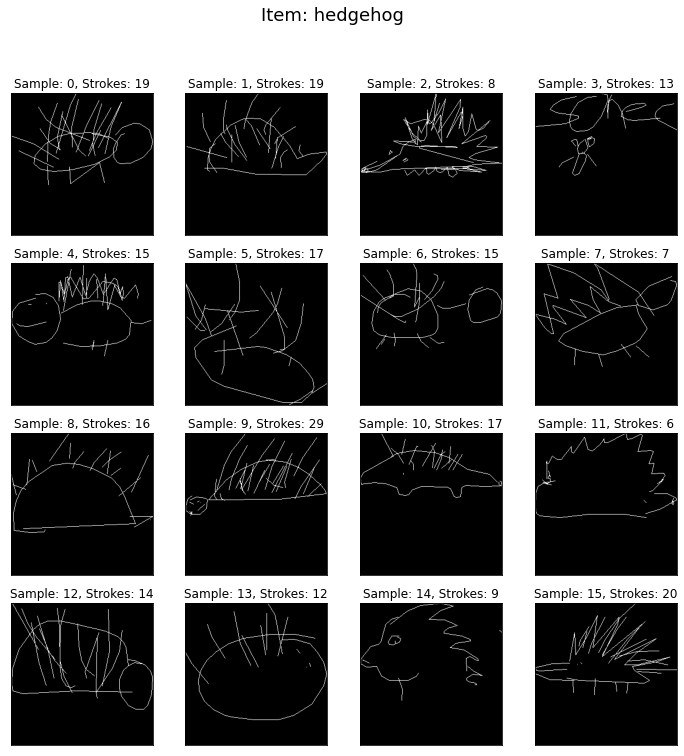

In [6]:
plt.figure(figsize=(12,12))

for plot_index, sample_id in enumerate(range(16)):

    sample = data[sample_id]

    drawing_sample = sample['drawing']

    drawing_image = np.zeros([256, 256])
    for stroke_num, stroke in enumerate(drawing_sample):
        x = stroke[0]
        y = stroke[1]
        assert len(x) == len(y)
        for pixel in range(len(x)-1):
            # drawing_image[y[pixel], x[pixel]] = 1
            rr, cc = draw.line(y[pixel], x[pixel],
                               y[pixel+1], x[pixel+1])
            drawing_image[rr, cc] = 1

    plt.subplot(4,4,plot_index+1)
    plt.imshow(drawing_image,
                cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Sample: {}, Strokes: {}'.format(sample_id, len(drawing_sample)))
plt.suptitle('Item: {}'.format(data[0]['word']),
             fontsize=18)
plt.show();